## Import lib

In [1]:
from DataSet import DataSet
from SimGPBO_old import SimGPBO_old
from SimGPBO import SimGPBO
from PostProcessor import PostProcessor
import GPy
import numpy as np 
import matplotlib.pyplot as plt
import copy 
import torch 
import gpytorch
from GPcustom.models import GPytorchModel

In [2]:
def plot_map(ds: DataSet, vector: np.array, title: str=None) -> None:
    map = np.full((
                        np.max(ds.set['ch2xy'][:,0]),
                        np.max(ds.set['ch2xy'][:,1])
                        ), 
                        np.nan)
    for i in range(ds.set['ch2xy'].shape[0]):
        map[int(ds.set['ch2xy'][i,0]-1),int(ds.set['ch2xy'][i,1]-1)] = vector[i]
    plt.figure()
    plt.imshow(map, cmap='viridis', vmin=np.nanmin(map), vmax=np.nanmax(map))
    plt.colorbar(label="values")
    plt.title(title)
    plt.show()


## Import data

In [2]:
ds = DataSet('../data/','nhp','Cebus1_M1_190221.mat','cebus1')
ds.load_matlab_data() # load data from the dataset_file

## Simulation 

In [5]:
sim = SimGPBO(name = 'test_og', 
                    ds = copy.deepcopy(ds),
                    AF = 'UCB',
                    NB_REP = 1,
                    NB_IT = 100,
                    KAPPA = 6,
                    NB_RND = 1
                    )

sim.select_emgs([0])

sim.run_simulations(gp_origin='gpytorch', response_type='valid', 
                         hyperparams_storage=True, HP_estimation=True, manual_seed=True)

Global Progress:   0%|          | 0/1 [00:00<?, ?iter/s]

Global Progress: 100%|██████████| 1/1 [02:00<00:00, 120.14s/iter]

Elapsed time: 120.1486668586731 seconds
final save of test_og in:   results/gpbo_gpytorch_UCB_cebus1_test_og.npz


In [6]:
sim = SimGPBO(name = 'test_pseudo_gpy', 
                    ds = copy.deepcopy(ds),
                    AF = 'UCB',
                    NB_REP = 1,
                    NB_IT = 100,
                    KAPPA = 6,
                    NB_RND = 1
                    )

sim.select_emgs([0])

sim.run_simulations(gp_origin='estimated_gpytorch', response_type='valid', 
                         hyperparams_storage=True, HP_estimation=False, manual_seed=True)

Global Progress: 100%|██████████| 1/1 [01:38<00:00, 98.56s/iter]

Elapsed time: 98.5767297744751 seconds
final save of test_pseudo_gpy in:   results/gpbo_estimated_gpytorch_UCB_cebus1_test_pseudo_gpy.npz


In [3]:
sim = SimGPBO(name = 'test_pseudo_hp', 
                    ds = copy.deepcopy(ds),
                    AF = 'UCB',
                    NB_REP = 1,
                    NB_IT = 100,
                    KAPPA = 6,
                    NB_RND = 1
                    )

sim.select_emgs([0])

sim.run_simulations(gp_origin='estimated_hp_gpytorch', response_type='valid', 
                         hyperparams_storage=True, HP_estimation=False, manual_seed=True)

Global Progress:   0%|          | 0/1 [00:00<?, ?iter/s]

Global Progress: 100%|██████████| 1/1 [01:10<00:00, 70.24s/iter]

Elapsed time: 70.23801374435425 seconds
final save of test_pseudo_hp in:   results/gpbo_estimated_hp_gpytorch_UCB_cebus1_test_pseudo_hp.npz


In [6]:
sim.QI.hyperparams

{'lengthscale': [0.09486876871081606, 0.050002679885254586],
 'outputscale': 0.8374112910765759,
 'noise': 0.00129780899072611}

In [7]:
sim.QI_hyperparams_outputscale

tensor([[[[0.7554, 0.5135]]]], dtype=torch.float64)

In [25]:
mean, std = sim.gp.predict(sim.X_test_normed)

In [26]:
ds.set['sorted_respMean'].shape

(96, 6)

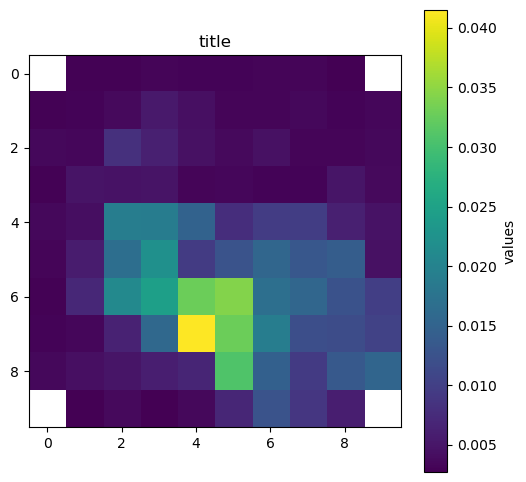

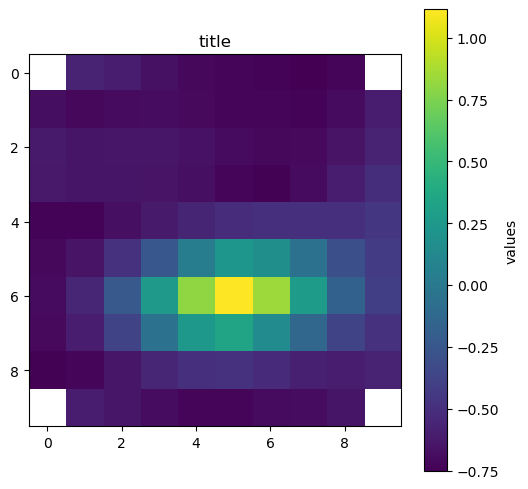

In [27]:
map_emg = np.full((ds.set['sorted_respMean'].shape[1],
                    np.max(ds.set['ch2xy'][:,0]),
                    np.max(ds.set['ch2xy'][:,1])
                    ), 
                    np.nan)
for i in range(ds.set['ch2xy'].shape[0]):
    map_emg[:,int(ds.set['ch2xy'][i,0]-1),int(ds.set['ch2xy'][i,1]-1)] = ds.set['sorted_respMean'][i,:]
# print(map_emg)

plt.figure(figsize=(6, 6))
plt.imshow(map_emg[0], cmap='viridis', vmin=np.nanmin(map_emg[0]), vmax=np.nanmax(map_emg[0]))
plt.colorbar(label="values")
plt.title("title")
plt.show()

map_mean = np.full((
                    np.max(ds.set['ch2xy'][:,0]),
                    np.max(ds.set['ch2xy'][:,1])
                    ), 
                    np.nan)
for i in range(ds.set['ch2xy'].shape[0]):
    map_mean[int(ds.set['ch2xy'][i,0]-1),int(ds.set['ch2xy'][i,1]-1)] = mean[i]
# print(map_emg)

plt.figure(figsize=(6, 6))
plt.imshow(map_mean, cmap='viridis', vmin=np.nanmin(map_mean), vmax=np.nanmax(map_mean))
plt.colorbar(label="values")
plt.title("title")
plt.show()

In [28]:
sim.QI.query_map

array([[0, 0, 0, 0, 1, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 1, 0, 0, 1],
       [1, 0, 0, 0, 2, 8, 0, 1, 0, 1],
       [0, 0, 0, 1, 0, 0, 1, 1, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 1, 0]])

In [22]:
sim.QI.mean_map

array([[       nan, 0.00269586,        nan,        nan,        nan,
               nan,        nan,        nan, 0.00292534,        nan],
       [       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan, 0.00230667],
       [0.00336139,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan],
       [0.00415822,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan, 0.00407064],
       [0.00428947,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan, 0.00347902],
       [0.00312846,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan, 0.00533813],
       [       nan, 0.00427509,        nan,        nan,        nan,
               nan,        nan,        nan,        nan, 0.01061169],
       [0.00218707,        nan,        na

In [31]:
sim.QI.var_map

array([[           nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan],
       [           nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan],
       [           nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan],
       [           nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan],
       [           nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan],
       [           nan,            nan,            nan,            nan,
   

In [30]:
np.nanmean(sim.QI.var_map)

9.057918250545125e-05

In [37]:
sim.QI.get_mean_queries()

[[(0.1111111111111111, 0.6666666666666666), 0.006246895529329777],
 [(1.0, 0.1111111111111111), 0.0026290242094546556]]

In [38]:
sim.last_used_train_X

tensor([[0.1111, 0.6667],
        [1.0000, 0.1111]], dtype=torch.float64)

In [39]:
sim.last_used_train_Y

tensor([ 0.7071, -0.7071], dtype=torch.float64)

In [32]:
sim.QI.estimate_HP()

In [40]:
mean_queries = sim.QI.get_mean_queries()
train_x = torch.tensor([list(item[0]) for item in mean_queries], dtype=torch.float64)
train_y = torch.tensor([item[1] for item in mean_queries], dtype=torch.float64)
print(train_x)
print(train_y)

tensor([[0.1111, 0.6667],
        [1.0000, 0.1111]], dtype=torch.float64)
tensor([0.0062, 0.0026], dtype=torch.float64)


In [34]:
np.sum(sim.QI.query_map)

1

In [21]:
if np.sum(sim.QI.query_map) == 1:
    sim.QI.likelihood = gpytorch.likelihoods.GaussianLikelihood()
    sim.QI.gp = GPytorchModel(
                train_x=train_x,
                train_y=train_y,
                likelihood=sim.QI.likelihood,
                kernel_type='Matern52'
            )
else:
    sim.QI.gp.set_train_data(
        train_x,
        train_y,
        strict=False,
    )
    


In [22]:

sim.QI.gp.double()

# Find optimal model hyperparameters
sim.QI.gp.train_model(train_x, train_y, max_iters=100, lr=0.1, Verbose=False)
sim.QI.hyperparams = sim.QI.gp.get_hyperparameters()

In [23]:
sim.QI.hyperparams

{'lengthscale': [1.9999999998305922, 1.9999999997790165],
 'outputscale': 0.5000000000553386,
 'noise': 0.0010000000476043044}

In [5]:
mean = sim.gp.mean.detach().numpy()
std = sim.gp.std.detach().numpy()
best_f = np.max(sim.gp.mean[sim.best_pred_x_measured[0, 0, 0, 39].item()].numpy())

In [9]:
map_emg = np.full((ds.set['sorted_respMean'].shape[1],
                    np.max(ds.set['ch2xy'][:,0]),
                    np.max(ds.set['ch2xy'][:,1])
                    ), 
                    np.nan)
for i in range(ds.set['ch2xy'].shape[0]):
    map_emg[:,int(ds.set['ch2xy'][i,0]-1),int(ds.set['ch2xy'][i,1]-1)] = ds.set['sorted_respMean'][i,:]
# print(map_emg)

map_mean = np.full((
                    np.max(ds.set['ch2xy'][:,0]),
                    np.max(ds.set['ch2xy'][:,0])
                    ), 
                    np.nan)
for i in range(ds.set['ch2xy'].shape[0]):
    map_mean[int(ds.set['ch2xy'][i,0]-1),int(ds.set['ch2xy'][i,1]-1)] = mean[i]
# print(map_mean)

plt.figure(figsize=(6, 6))
plt.imshow(map_emg[3], cmap='viridis', vmin=np.nanmin(map_emg[3]), vmax=np.nanmax(map_emg[3]))
plt.colorbar(label="values")
plt.title("title")
plt.show()

plt.figure(figsize=(6, 6))
plt.imshow(map_mean, cmap='viridis', vmin=np.nanmin(map_mean), vmax=np.nanmax(map_mean))
plt.colorbar(label="values")
plt.title("title")
plt.show()

In [31]:
print(sim.P_test_x_idx)
print(sim.P_test_y)

tensor([[[[61,  7, 88, 78, 89, 79, 88, 94, 87, 18,  1, 30, 47,  8, 77, 48, 37,
           38, 14, 24, 28, 32, 43, 21, 22, 31, 11, 20, 42, 33, 34, 45, 64, 35,
           83,  3, 40, 17, 56, 59]]]])
tensor([[[[0.0024, 0.0022, 0.0029, 0.0022, 0.0024, 0.0021, 0.0025, 0.0064,
           0.0033, 0.0091, 0.0034, 0.0179, 0.0022, 0.0145, 0.0024, 0.0040,
           0.0028, 0.0043, 0.0060, 0.0099, 0.0102, 0.0324, 0.0132, 0.0372,
           0.0199, 0.0199, 0.0186, 0.0114, 0.0094, 0.0383, 0.0347, 0.0142,
           0.0021, 0.0167, 0.0022, 0.0044, 0.0130, 0.0048, 0.0031, 0.0073]]]],
       dtype=torch.float64)
